# 1 Etude du problème d’optimisation





#### Q1 
La minimisation de $K(x_{N}-L/2)^2$ permet de répondre à la contrainte d'arrosage : on doit arroser le parterre de fleur situé en (0,1). On cherche donc à minimiser la distance du bout du tuyau à ce point d'intérêt. 
La minimisation de la quantité $\sum_{i=0}^N{\lvert y_{i}\rvert}$ traduit la minimisation de la hauteur moyenne du tuyau (selon l'axe y). En minimisant cette somme on cherche à "compacter" le tuyau proche de l'axe x.


#### Q2
La valeur initiale qu'on doit donner au solveur doit vérifier les contraintes. Il serait compliqué de trouver/prouver l'existence d'une telle solution ie avec deux conditions aux bords ainsi qu'une condition de courbure (la courbure à des conditions aux bords et elle est bornée).

#### Q3
Les $y_{i}\mapsto\lvert y_{i}\rvert$ ne sont pas différentiables sur $\mathbb{R}$. Ce manque de régularité pose évidemment problème dans l'algorithme de minimisation. 



#### Q4
 
 On a $\min{\lvert y_{i} \rvert}=\max{y_{i},-y{i}}$\
 Or avec $-y_{i} \leq w_{i}$ et $y_{i} \leq w_{i}$

On a donc $max{y_{i},-y_{i}} \leq w_{i}$\
On minimise donc $w_{i}$ en prenant : $w_{i}=max{y_{i},-y_{i}}$/

Minimiser $\lvert y_{i} \rvert$ revient donc à minimiser $w_{i}$


#### Q5
On considère la variable de décision : 
$z = (\theta_{0},...,\theta_{N-1},x_{0},...,x_{N},y_{0},...,y_{N},w_{0},...w_{N})$\
La fonction cout : 
$f:z\mapsto K(x_{N}-L/2)^2+ ds\sum_{i=0}^{N}{w_{i}}$\
La fonction contrainte inégalité :
$c_{ineq}:z\mapsto (\theta_{1}-\theta_{0} -\alpha ds,\theta_{0}-\theta_{1} -\alpha ds,...,\theta_{N-1}-\theta_{N-2} -\alpha ds,...,\theta_{N-2}-\theta_{N-1} -\alpha ds,-w_{0}-y_{0},-w_{0}+y_{0},...,-w_{N}-y_{N},-w_{N}+y_{N})$\
La fonction contrainte égalité :
$c_{eq}:z\mapsto (\theta_{0},\theta_{N-1},x_{0},y_{0}-1,y{N},x_{1}-x_{0}- ds cos(\theta_{0}),...,x_{N}-x_{N-1}- ds cos(\theta_{N-1}),y_{1}-y_{0}- ds sin(\theta_{0}),...,y_{N}-y_{N-1}- dssin(\theta_{N-1}))$



# 2 Etude et résolution numériques


#### Q6
On peut implémenter un algorithme de résolution avec Scipy ou Casadi. Afin de résoudre ce problème d'optimisation, nous allons utiliser le solveur SLSQP qui est dans le module Scipy.


#### Q7

0.2
[0.         0.2        0.39891197 0.59782394 0.79673591 0.99564788
 1.19455986 1.39347183 1.5923838  1.79129577 1.99020774 2.18911971
 2.38803168 2.58694365 2.78585562 2.98476759 3.18367957 3.38259154
 3.58150351 3.78041548 3.97932745 4.17823942 4.37715139 4.57606336
 4.77497533 4.9738873  5.17279928 5.37171125 5.57062322 5.76953519
 5.96844716 6.16735913 6.3662711  6.56518307 6.76409504 6.96300702
 7.16191899 7.36083096 7.55974293 7.7586549  7.95756687 8.15647884
 8.35539081 8.55430278 8.75321475 8.95212673 9.1510387  9.34995067
 9.54886264 9.74777461 9.94777461]


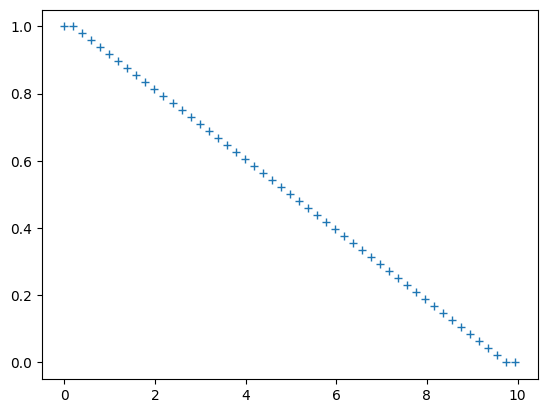

In [8]:
import numpy as np
import matplotlib.pyplot as plt

K=1
N=50
L=10
ds=L/N
a=1
thetamax=a*ds


def ConditionInitDroite(N,ds):
    ##1)on trouve dans un premier temps la condition initiale :
    m=N+(N+1)+(N+1)+(N+1)
    z_0=np.zeros(m) #theta initial est nul
    #en tracant la droite reliant les point (1,0) et l'axe des abscisses en prenant compte des theta initial et final, theta est donc constant
    theta = -np.arcsin(1/((L-2*ds)))
    z_0[2*N+1]=1
    z_0[3*N+2]=1
    for i in range (1,N-1) :
        z_0[i]=theta
    for i in range (N+1,2*N+1):
        z_0[i]=z_0[i-1]+ds*np.cos(z_0[i-(N+1)])
        z_0[i+N+1]=z_0[i+N]+ds*np.sin(z_0[i-(N+1)])
        z_0[i+2*(N+1)]=z_0[i+N+1]
    return z_0

z_0=ConditionInitDroite(N,ds)
print(thetamax)
print(z_0[N:2*N+1])
plt.plot(z_0[N:2*N+1],z_0[2*N+1:3*N+2],"+")
    
    

In [2]:
import numpy as np
from scipy.optimize import minimize

#Définition de la fonction coût
def cout(z):
    return K*(z[2*N]-L/2)**2 + ds*np.sum(z[3*N+2:]) # La somme correspond à la somme des Omega_i

#Définition des contraintes

#Attention les contraintes sont du côté positif, d'après la doc : 'Equality constraint means that the 
# constraint function result is to be zero whereas inequality means that it is to be non-negative.'

def vectContrainte(N,ds):

    def contrainte_theta0(z):
        return z[0]
    def contrainte_thetaN1(z):
        return z[N-1]
    def contrainte_x0(z):
        return z[N]
    def contrainte_y0(z):
        return z[2*N+1]-1
    def contrainte_yN(z):
        return z[3*N+1]
    
    def créer_contraintes_i_1_theta(i):
        def contrainte(z):
            return z[i+1]-z[i]+a*ds
        return contrainte

    def créer_contraintes_i_2_theta(i):
        def contrainte(z):
            return z[i]-z[i+1]+a*ds
        return contrainte

    def créer_contraintes_i_1_omega(i):
        def contrainte(z):
            return z[3*N+2+i]-z[2*N+1+i]
        return contrainte

    def créer_contraintes_i_2_omega(i):
        def contrainte(z):
            return z[3*N+2+i]+z[2*N+1+i]
        return contrainte

    def créer_contraintes_e_x(i):
        def contrainte(z):
            return z[N+1+i]-z[N+i]-ds*np.cos(z[i])
        return contrainte

    def créer_contraintes_e_y(i):
        def contrainte(z):
            return z[2*N+2+i]-z[2*N+1+i]-ds*np.sin(z[i])
        return contrainte

    contraintes=[]
    #Ajout des contraintes égalités qui ne dépendent pas de i
    contraintes.append({'type': 'eq', 'fun': contrainte_theta0})
    contraintes.append({'type': 'eq', 'fun': contrainte_thetaN1})
    contraintes.append({'type': 'eq', 'fun': contrainte_x0})
    contraintes.append({'type': 'eq', 'fun': contrainte_y0})
    contraintes.append({'type': 'eq', 'fun': contrainte_yN})


    #Ajout des contraintes qui dépendent de i, d'abord les inégalités puis les égalités
    for i in range(N):
        contraintes.append({'type': 'ineq', 'fun': créer_contraintes_i_1_theta(i)})
    for i in range(N):
        contraintes.append({'type': 'ineq', 'fun': créer_contraintes_i_2_theta(i)})
    for i in range(N+1):
        contraintes.append({'type': 'ineq', 'fun': créer_contraintes_i_1_omega(i)})
    for i in range(N+1):
        contraintes.append({'type': 'ineq', 'fun': créer_contraintes_i_2_omega(i)})
    for i in range(N):
        contraintes.append({'type': 'eq', 'fun': créer_contraintes_e_x(i)})
    for i in range(N):
        contraintes.append({'type': 'eq', 'fun': créer_contraintes_e_y(i)})

    return contraintes

In [6]:
contraintes=vectContrainte(N,ds)
sol = minimize(cout,z_0,method='SLSQP', constraints=contraintes)
print(sol)

#On affiche la solution pour voir si la minimisation a fonctionné

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 8.393576046150326
       x: [ 0.000e+00 -2.000e-01 ... -6.677e-16  7.642e-17]
     nit: 48
     jac: [ 0.000e+00  0.000e+00 ...  2.000e-01  2.000e-01]
    nfev: 9793
    njev: 48


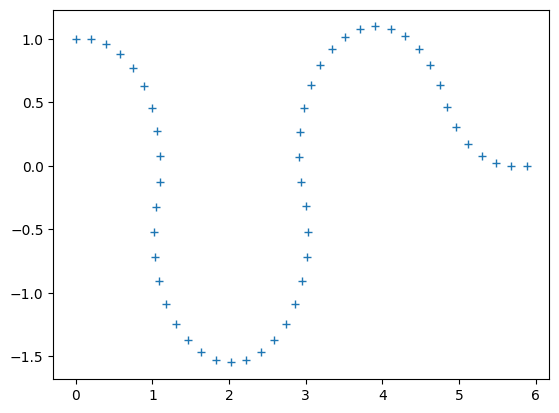

In [ ]:
plt.plot(sol.x[N:2*N+1],sol.x[2*N+1:3*N+2])

# Q8


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 9.045824266683086
       x: [ 0.000e+00 -2.000e-01 ...  6.193e-16  1.610e-15]
     nit: 53
     jac: [ 0.000e+00  0.000e+00 ...  2.000e-01  2.000e-01]
    nfev: 10814
    njev: 53


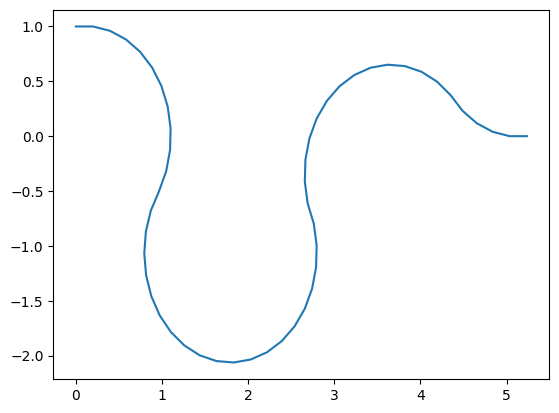

In [8]:
#Tracé pour K=5
K=5
N=50
L=10
ds=L/N
a=1
thetamax=a*ds
z_0=ConditionInitDroite(N,ds)
contraintes=vectContrainte(N,ds)
sol2=minimize(cout,z_0,method='SLSQP', constraints=contraintes)
print(sol2)
plt.plot(sol2.x[N:2*N+1],sol2.x[2*N+1:3*N+2])

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 10.50644630290102
       x: [ 0.000e+00  2.000e-01 ...  2.491e-15  2.359e-15]
     nit: 66
     jac: [ 0.000e+00  0.000e+00 ...  2.000e-01  2.000e-01]
    nfev: 13467
    njev: 66


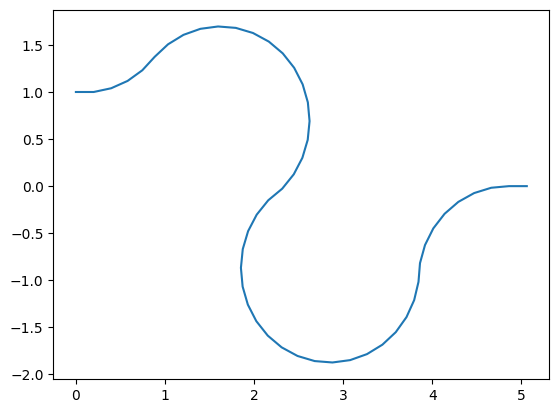

In [9]:
#Tracé pour K=10
K=10
N=50
L=10
ds=L/N
a=1
thetamax=a*ds
z_0=ConditionInitDroite(N,ds)
contraintes=vectContrainte(N,ds)
sol3=minimize(cout,z_0,method='SLSQP', constraints=contraintes)
print(sol3)
plt.plot(sol3.x[N:2*N+1],sol3.x[2*N+1:3*N+2])

# Q9

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 10.496225482699257
       x: [ 0.000e+00  1.429e-01 ...  1.084e-15  3.107e-15]
     nit: 49
     jac: [ 0.000e+00  0.000e+00 ...  1.429e-01  1.429e-01]
    nfev: 13921
    njev: 49
0.14285714285714285
0.14285714285715975


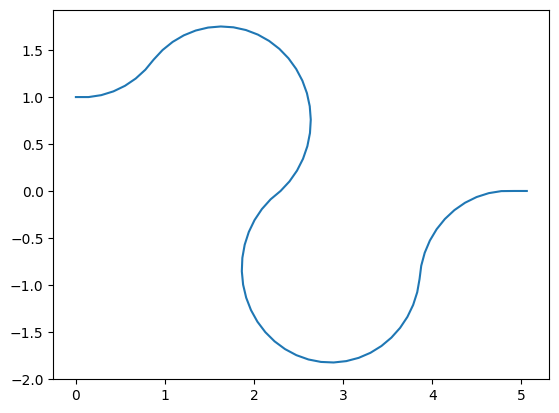

In [6]:
#Tracé pour K=10 et N=70
K=10
N=70
L=10
ds=L/N
a=1
thetamax=a*ds
z_0=ConditionInitDroite(N,ds)
contraintes=vectContrainte(N,ds)
sol4=minimize(cout,z_0,method='SLSQP', constraints=contraintes)
print(sol4)
print(thetamax)
print(sol4.x[1]-sol4.x[0])
plt.plot(sol4.x[N:2*N+1],sol4.x[2*N+1:3*N+2])

0.1111111111111111
0.1111111111111866
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 10.428712649929262
       x: [ 0.000e+00  1.111e-01 ... -4.695e-15 -4.964e-15]
     nit: 44
     jac: [ 0.000e+00  0.000e+00 ...  1.111e-01  1.111e-01]
    nfev: 16020
    njev: 44


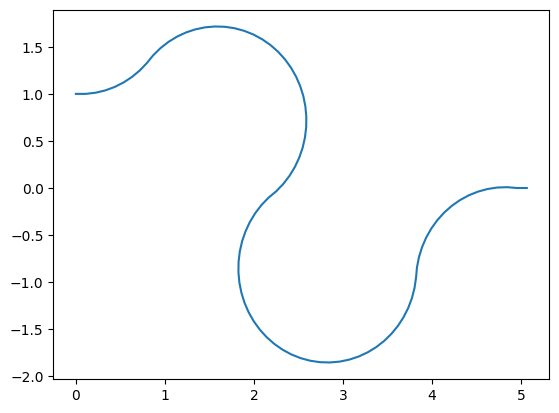

In [7]:
#Tracé pour K=10 et N=90
K=10
N=90
L=10
ds=L/N
a=1
thetamax=a*ds
z_0=ConditionInitDroite(N,ds)
contraintes=vectContrainte(N,ds)
sol5=minimize(cout,z_0,method='SLSQP', constraints=contraintes)
print(thetamax)
print(sol5.x[1]-sol5.x[0])
print(sol5)
plt.plot(sol5.x[N:2*N+1],sol5.x[2*N+1:3*N+2])

# Q10

● La veleur de $\beta$ doit faire en sorte que le tuyaux soit de longueur L. On calcule ainsi la longueur du tuyaux en fonction de $\beta$ et en prenant $\alpha=1$.\
On obtient ainsi : $L=\pi + 1 + \frac{\pi}{\beta} \Rightarrow \beta=\frac{\pi}{L-\pi-1}$\
Il vient: $\beta \approx 0.54$

Maintenant vérifions que cette valeur de $\beta$ correspond à une valeur initiale qui vérifie les contraintes.

La nouvelle valeur initiale doit respecter les contraintes et particulièrement la contrainte de courbure. Calculons ainsi $\Delta \theta$ au long de la trajectoire entre le troisième point et le quatrième point du schéma (qui fera intervenir $\beta$).
$\Delta \theta$ sera constant car la trajectoire est une portion de cercle.

Calculons dans un premier temps le nombre de points n entre le point 3 et le point 4 :
$n=\frac{\pi r }{ds}$\
Avec $r=\frac{1}{\beta}$ on obtient : $n=\frac{\pi}{\beta ds}$\
Entre le point 3 et 4 on tourne de $\pi$ ainsi : $(n-1)\Delta \theta=\pi$\
On doit donc respecter : $\frac{\pi}{n-1} \leq \alpha ds \Rightarrow \beta \leq \frac{1}{\frac{ds}{\pi}+\frac{1}{\alpha}} \approx 0.94$

La valeur de $\beta$ trouvée précedemment est donc valable.

● Implémentons maintenant cette solution initiale :

50
0.2
-0.10833078115827
7 5 30 8
[ 0.         -0.26179939 -0.52359878 -0.78539816 -1.04719755 -1.30899694
 -1.57079633 -1.57079633 -1.57079633 -1.57079633 -1.57079633 -1.57079633
 -1.46246555 -1.35413476 -1.24580398 -1.1374732  -1.02914242 -0.92081164
 -0.81248086 -0.70415008 -0.5958193  -0.48748852 -0.37915773 -0.27082695
 -0.16249617 -0.05416539  0.05416539  0.16249617  0.27082695  0.37915773
  0.48748852  0.5958193   0.70415008  0.81248086  0.92081164  1.02914242
  1.1374732   1.24580398  1.35413476  1.46246555  1.57079633  1.67912711
  1.41732772  1.15552833  0.89372894  0.63192956  0.37013017  0.10833078
  0.          0.          0.          0.2         0.39318517  0.56639025
  0.7078116   0.8078116   0.85957541  0.85957541  0.85957541  0.85957541
  0.85957541  0.85957541  0.85957541  0.88119921  0.9241933   0.98805361
  1.07203143  1.1751422   1.29617704  1.43371694  1.58614935  1.75168715
  1.92838956  2.1141849   2.3068949   2.5042602   2.70396688  2.90367357
  3.10103887  3.2

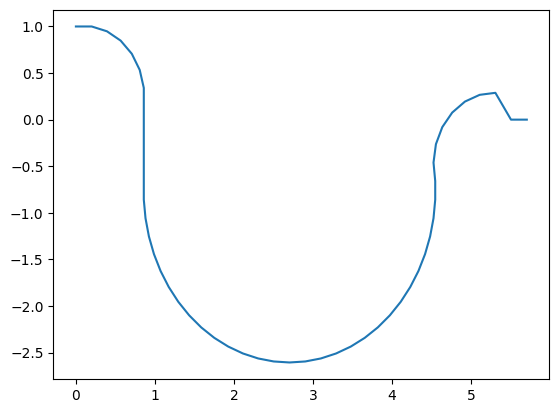

In [11]:
K=10
N=50
L=10
ds=L/N
a=1
thetamax=a*ds
beta=np.pi/(L-np.pi-1)

#Contraintes:

#On va compter le nombre de points et l'angle de courbure pour chaque portion de la valeur initiale, on en trouve 48 du aux parties entières,
#on en rajoute 2 donc deux

#Portion 1:
N1=int((np.pi)/(2*ds))
dtheta1=(np.pi)/(2*(N1-1))
#Portion 2:
N2=int(1/ds)
dtheta2=0
#Portion 2:
N2=int(1/ds)
dtheta2=0
#Portion 3:
N3=int(np.pi/(beta*ds))+1
dtheta3=(np.pi)/(N3-1)
#Portion 4: meme que portion 1
N4=N1+1
dtheta4=dtheta1   



N_r=N1+N2+N3+N4
m=N_r+(N_r+1)+(N_r+1)+(N_r+1)
z_02=np.zeros(m)
z_02[0]=0
z_02[N_r]=0
z_02[3*N_r+1]=0
z_02[2*N_r+1]=1
z_02[3*N_r+2]=1

#on rentre les theta

for i in range (1,N1):
    z_02[i]+=z_02[i-1]-dtheta1

for i in range (N1,N1+N2):
    z_02[i]+=z_02[i-1]+dtheta2


for i in range (N1+N2,N1+N2+N3):
    z_02[i]+=z_02[i-1]+dtheta3


for i in range (N1+N2+N3,N1+N2+N3+N4-1):
    z_02[i]+=z_02[i-1]-dtheta4
    
#Puis les x, les y et les w:

#Portion1
for i in range (N_r+1,N_r+N1):
    z_02[i]=z_02[i-1]+ds*np.cos(z_02[i-(N_r+1)])
    z_02[i+N_r+1]=z_02[i+N_r]+ds*np.sin(z_02[i-(N_r+1)])
    z_02[i+2*(N_r+1)]=z_02[i+N_r+1]

#Portion2
for i in range (N_r+N1,N_r+N1+N2):
    z_02[i]=z_02[i-1]+ds*np.cos(z_02[i-(N_r+1)])
    z_02[i+N_r+1]=z_02[i+N_r]+ds*np.sin(z_02[i-(N_r+1)])
    z_02[i+2*(N_r+1)]=z_02[i+N_r+1]
    
#Portion3
for i in range (N_r+N1+N2,N_r+N1+N2+N3):
    z_02[i]=z_02[i-1]+ds*np.cos(z_02[i-(N_r+1)])
    z_02[i+N_r+1]=z_02[i+N_r]+ds*np.sin(z_02[i-(N_r+1)])
    z_02[i+2*(N_r+1)]=z_02[i+N_r+1]
    
#Portion4
for i in range (N_r+N1+N2+N3,N_r+N1+N2+N3+N4+1):
    z_02[i]=z_02[i-1]+ds*np.cos(z_02[i-(N_r+1)])
    z_02[i+N_r+1]=z_02[i+N_r]+ds*np.sin(z_02[i-(N_r+1)])
    z_02[i+2*(N_r+1)]=z_02[i+N_r+1]
    
z_02[3*N_r+1]=0
z_02[4*N_r+2]=0
z_02[3*N_r]=0
z_02[4*N_r]=0
z_02[N-2]=0

print(N_r)
print(ds)
print(z_02[N_r-2]-z_02[N_r-3])
print(N1,N2,N3,N4)
print(z_02)

plt.plot(z_02[N_r:2*N_r+1],z_02[2*N_r+1:3*N_r+2])

# 3 Ajout d’obstacles

# Q11

In [13]:
contraintes=vectContrainte(N,ds)
sol_02 = minimize(cout,z_02,method='SLSQP', constraints=contraintes)
print(sol_02)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 9.153020103326794
       x: [ 0.000e+00 -2.000e-01 ... -2.077e-15 -3.386e-15]
     nit: 29
     jac: [ 0.000e+00  0.000e+00 ...  2.000e-01  2.000e-01]
    nfev: 5922
    njev: 29


In [ ]:
plt.plot(sol_02.x[N:2*N+1],sol_02.x[2*N+1:3*N+2])
print(N_r)

# Q12


In [13]:
taille_parterres=[0.5,0.5]
parterres=[[2,-1],[3,1]]

def vectContrainte_parterre(N,ds):

    def contrainte_theta0(z):
        return z[0]
    def contrainte_thetaN1(z):
        return z[N-1]
    def contrainte_x0(z):
        return z[N]
    def contrainte_y0(z):
        return z[2*N+1]-1
    def contrainte_yN(z):
        return z[3*N+1]
    
    def créer_contraintes_i_1_theta(i):
        def contrainte(z):
            return z[i+1]-z[i]+a*ds
        return contrainte

    def créer_contraintes_i_2_theta(i):
        def contrainte(z):
            return z[i]-z[i+1]+a*ds
        return contrainte

    def créer_contraintes_i_1_omega(i):
        def contrainte(z):
            return z[3*N+2+i]-z[2*N+1+i]
        return contrainte

    def créer_contraintes_i_2_omega(i):
        def contrainte(z):
            return z[3*N+2+i]+z[2*N+1+i]
        return contrainte

    def créer_contraintes_e_x(i):
        def contrainte(z):
            return z[N+1+i]-z[N+i]-ds*np.cos(z[i])
        return contrainte

    def créer_contraintes_e_y(i):
        def contrainte(z):
            return z[2*N+2+i]-z[2*N+1+i]-ds*np.sin(z[i])
        return contrainte
    
    def créer_contraintes_parterre(i,j):
        def contrainte(z):
            return (z[N+i]-parterres[j][0])**2 + (z[2*N+1+i]-parterres[j][1])**2 - taille_parterres[j]**2
        return contrainte

    contraintes=[]
    #Ajout des contraintes égalités qui ne dépendent pas de i
    contraintes.append({'type': 'eq', 'fun': contrainte_theta0})
    contraintes.append({'type': 'eq', 'fun': contrainte_thetaN1})
    contraintes.append({'type': 'eq', 'fun': contrainte_x0})
    contraintes.append({'type': 'eq', 'fun': contrainte_y0})
    contraintes.append({'type': 'eq', 'fun': contrainte_yN})


    #Ajout des contraintes qui dépendent de i, d'abord les inégalités puis les égalités
    for i in range(N):
        contraintes.append({'type': 'ineq', 'fun': créer_contraintes_i_1_theta(i)})
    for i in range(N):
        contraintes.append({'type': 'ineq', 'fun': créer_contraintes_i_2_theta(i)})
    for i in range(N+1):
        contraintes.append({'type': 'ineq', 'fun': créer_contraintes_i_1_omega(i)})
    for i in range(N+1):
        contraintes.append({'type': 'ineq', 'fun': créer_contraintes_i_2_omega(i)})
    for i in range(N):
        contraintes.append({'type': 'eq', 'fun': créer_contraintes_e_x(i)})
    for i in range(N):
        contraintes.append({'type': 'eq', 'fun': créer_contraintes_e_y(i)})

    for i in range(N+1):
        for j in range(len(taille_parterres)):
            contraintes.append({'type': 'ineq', 'fun': créer_contraintes_parterre(i,j)})

    return contraintes


In [14]:
K=10
N=50
L=10
ds=L/N
a=1
contraintes2=vectContrainte_parterre(N,ds)
sol_022=minimize(cout,z_02,method='SLSQP', constraints=contraintes2)
print(sol_022)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 9.153020103327023
       x: [ 0.000e+00 -2.000e-01 ... -4.573e-16  6.844e-16]
     nit: 29
     jac: [ 0.000e+00  0.000e+00 ...  2.000e-01  2.000e-01]
    nfev: 5922
    njev: 29


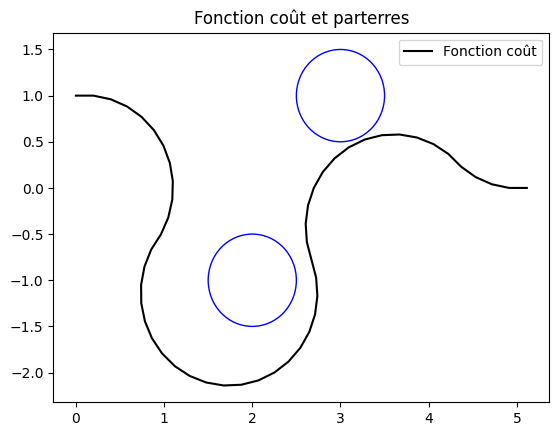

In [15]:
x=sol_022.x[N:2*N+1]
y=sol_022.x[2*N+1:3*N+2]

fig, ax=plt.subplots()

ax.plot(x, y, label="Fonction coût", color="black")
    
cercle1=plt.Circle(parterres[0], taille_parterres[0], color='blue', fill=False)
cercle2=plt.Circle(parterres[1], taille_parterres[1], color='blue', fill=False)

ax.add_patch(cercle1)
ax.add_patch(cercle2)

plt.legend()
plt.title("Fonction coût et parterres")
plt.show()


# 4 Minimum global

# Q13

Il est assez difficile de trouver une condition initiale qui respecte à la fois les contraintes d'angle et les contraintes de points. Ainsi en supprimant la contrainte $y_{N}=0$ et en rajoutant la pénalité $K_{2}y_{N}^2$ on facilite la recherche de solution initiale tout en gardant l'objectif d'avoir $y_{N} \approx 0$.

# Q14

In [ ]:
# Génération 